# Librerías

In [ ]:
!pip install pycaret

In [ ]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# Modelos
from lightgbm import LGBMClassifier
import pycaret
from pycaret.regression import *
from pycaret.clustering import *
from pycaret.classification import *

# Evaluación
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

# Gráficas
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Bases de datos

In [ ]:
# Base de datos de entrenamiento
df = pd.read_csv('Train_limpia.csv')
df.drop('Unnamed: 0', axis = 1, inplace = True)

# Sest de entrenamiento
x_train = df.drop("Survived", axis = 1)
y_train = df["Survived"]

In [ ]:
# Base de datos para prueba sin clasificaciones
test = pd.read_csv('Test_limpia.csv')

# Instancia con valor nulo de edad
r, _ = np.where(test.isna())
test = test.dropna(axis=0,how = "any")

In [ ]:
# Clasificaciones de la base de datos de prueba
y_test = pd.read_csv('submission_test.csv')
y_test = y_test.drop(r[0]) # valor nulo de edad
y_test.info()
y_test = np.array(y_test.Survived)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 417 entries, 0 to 417
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   PassengerId  417 non-null    int64
 1   Survived     417 non-null    int64
dtypes: int64(2)
memory usage: 9.8 KB


# Pycaret

En esta sección se hará uso de la librería de Pycaret para tener una visualización general de los resultados dependiendo de los diferentes modelos de clasificación. A partir de estos resultados, se hará la selección de modelos y experimentación para la mejora de las métricas. Cabe recalcar que estos modelos son entrenados y evaluados con el dataset de entrenamiento, por lo que se tienen menos datos para esto y los hiperparámetros encontrados puedan tener valores muy elevados que pueden llevar a un overfitting.

## Pycaret todas variables

Nuestra variable objetivo es Survived y es binaria, en total se tienen 9 características y 889 instancias, donde el 70% se destinó al  training set y 30% para el set de prueba.

In [ ]:
# Iniciar setup, se ingresa la base de datos de entrenamiento
s = setup(df, target = 'Survived', session_id = 123)

,Description,Value
0,Session id,123
1,Target,Survived
2,Target type,Binary
3,Original data shape,"(889, 9)"
4,Transformed data shape,"(889, 9)"
5,Transformed train set shape,"(622, 9)"
6,Transformed test set shape,"(267, 9)"
7,Numeric features,8
8,Preprocess,True
9,Imputation type,simple


En la siguiente tabla se observan los modelos de clasificación con mejor rendimiento en distintas métricas. Los primeros 3 pertenecen al grupo de modelos *Gradient Boosting* y el 4to es el *random forest*, estos modelos están basados en *decision trees*, sin embargo, la forma de integración es diferente en cada uno.

In [ ]:
# Training y selección de modelos
best = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8296,0.8514,0.7361,0.8087,0.7641,0.6321,0.6395,0.2690
xgboost,Extreme Gradient Boosting,0.8248,0.8403,0.7404,0.7915,0.7611,0.6237,0.6283,0.0900
gbc,Gradient Boosting Classifier,0.8102,0.8606,0.6938,0.7911,0.7345,0.5887,0.5955,0.3880
rf,Random Forest Classifier,0.8007,0.8340,0.7277,0.7492,0.7357,0.5761,0.5787,0.8270
ada,Ada Boost Classifier,0.7894,0.8421,0.7190,0.7293,0.7194,0.5515,0.5566,0.3820
lr,Logistic Regression,0.7878,0.8422,0.6766,0.7484,0.7051,0.5413,0.5476,0.8260
dt,Decision Tree Classifier,0.7878,0.7722,0.7150,0.7315,0.7187,0.5491,0.5532,0.0900
et,Extra Trees Classifier,0.7878,0.8252,0.6984,0.7338,0.7129,0.5454,0.5481,0.3670
ridge,Ridge Classifier,0.7829,0.0000,0.6685,0.7398,0.6983,0.5305,0.5353,0.0520
lda,Linear Discriminant Analysis,0.7829,0.8436,0.6726,0.7377,0.7004,0.5316,0.5356,0.1490


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

En este apartado se muestran distintas gráficas e información del mejor modelo, en este caso *Light Gradient Boosting Machine*.

In [ ]:
evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

## Pycaret sin SibSp y Parch

Debido al análisis de la importancia de las variables en la sección anterior, se decidió hacer un análisis sin las variables de SibSP y Parch, ya que son las que tienen valores menores.

Pudimos observar que los modelos sobresalientes son los mismos y que sus métricas no se alteran significativamente. Por lo que se decidió no eliminar estas características y considerar su eliminación en cada modelo individualmente en caso de ser necesario.

In [ ]:
s = setup(df.drop(['SibSp', 'Parch'], axis = 1), target = 'Survived', session_id = 123)

,Description,Value
0,Session id,123
1,Target,Survived
2,Target type,Binary
3,Original data shape,"(889, 7)"
4,Transformed data shape,"(889, 7)"
5,Transformed train set shape,"(622, 7)"
6,Transformed test set shape,"(267, 7)"
7,Numeric features,6
8,Preprocess,True
9,Imputation type,simple


In [ ]:
best = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8344,0.8554,0.7444,0.8131,0.7728,0.6435,0.6491,0.3060
xgboost,Extreme Gradient Boosting,0.8264,0.8416,0.7447,0.7932,0.7634,0.6273,0.6326,0.0860
rf,Random Forest Classifier,0.8135,0.8394,0.7406,0.7672,0.7507,0.6024,0.6055,0.3410
gbc,Gradient Boosting Classifier,0.8103,0.8634,0.6899,0.7923,0.7327,0.5878,0.5950,0.2090
qda,Quadratic Discriminant Analysis,0.7957,0.8318,0.7058,0.7489,0.7231,0.5620,0.5662,0.0470
et,Extra Trees Classifier,0.7942,0.8309,0.7150,0.7373,0.7244,0.5606,0.5622,0.4480
ada,Ada Boost Classifier,0.7910,0.8470,0.7188,0.7327,0.7212,0.5547,0.5594,0.1820
lda,Linear Discriminant Analysis,0.7910,0.8427,0.6726,0.7550,0.7077,0.5468,0.5519,0.0630
ridge,Ridge Classifier,0.7893,0.0000,0.6641,0.7560,0.7030,0.5420,0.5477,0.0420
dt,Decision Tree Classifier,0.7878,0.7754,0.7275,0.7249,0.7231,0.5515,0.5546,0.1050


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

# Balance de las variables objetivo


La proporción de los datos de entrenamiento es aproximadamente de 60% de no sobrevivientes, y 40% de sobrevivientes. Se procede con el balanceo de los datos con el fin de determinar si existe cierta "preferencia" por el modelo para los no sobrevivientes; en el caso de que se revise que las métricas de los modelos de ML son similares a la base de datos original, se dejará esta última para mantener la distribución de los datos a como sucedió en realidad.

In [ ]:
df["Survived"].value_counts()/len(df["Survived"])*100

0    61.754781
1    38.245219
Name: Survived, dtype: float64

Con esta funcion de oversampling, se puede conseguir que la proporcion entre sobrevivientes y no sobrevivientes sea la misma.

In [ ]:
from imblearn.over_sampling import RandomOverSampler
over_sampler = RandomOverSampler(random_state=42)
x_res, y_res = over_sampler.fit_resample(x_train, y_train)
print(f"Training target statistics: \n{y_res.value_counts()}")
#print(f"Testing target statistics: {Counter(y_test)}")

Training target statistics: 
0    549
1    549
Name: Survived, dtype: int64


## Comparación de modelos con los datos balanceados

In [ ]:
# Iniciar setup
s = setup(x_res, target = y_res, session_id = 123)

,Description,Value
0,Session id,123
1,Target,Survived
2,Target type,Binary
3,Original data shape,"(1098, 9)"
4,Transformed data shape,"(1098, 9)"
5,Transformed train set shape,"(768, 9)"
6,Transformed test set shape,"(330, 9)"
7,Numeric features,8
8,Preprocess,True
9,Imputation type,simple


In [ ]:
# Training y selección de modelos
best = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8319,0.8755,0.8410,0.8287,0.8328,0.6638,0.6671,0.3670
gbc,Gradient Boosting Classifier,0.8189,0.8859,0.8042,0.8294,0.8150,0.6376,0.6403,0.2110
xgboost,Extreme Gradient Boosting,0.8189,0.8852,0.8146,0.8215,0.8165,0.6377,0.6401,0.0980
et,Extra Trees Classifier,0.8150,0.8739,0.8122,0.8181,0.8140,0.6299,0.6317,0.4990
lightgbm,Light Gradient Boosting Machine,0.8137,0.8864,0.8018,0.8212,0.8105,0.6274,0.6288,0.4230
dt,Decision Tree Classifier,0.8098,0.8369,0.8148,0.8073,0.8101,0.6195,0.6210,0.0930
ada,Ada Boost Classifier,0.8046,0.8546,0.8148,0.8006,0.8058,0.6091,0.6123,0.2040
lr,Logistic Regression,0.7850,0.8519,0.7705,0.7930,0.7797,0.5700,0.5728,0.0610
ridge,Ridge Classifier,0.7798,0.0000,0.7316,0.8100,0.7669,0.5596,0.5642,0.0820
lda,Linear Discriminant Analysis,0.7798,0.8517,0.7316,0.8100,0.7669,0.5596,0.5642,0.0560


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

In [ ]:
evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

Debido a que las métricas de los modelos no mejoran de manera significativa, se decide continuar con la base de datos no balanceada.

# Modelos escogidos

## Light Gradient Boosting

Este modelo se basa en *decision trees* donde nuevos modelos se integran para corregir los errores de predicción de los anteriores.
Para la selección de los hiperparámetros, en un ciclo se entrenarán distintos modelos cambiando su valor, se obtendrán las métricas para cada modelo y se escogerán los valores donde se obtuvieron mejores resultados.

### Funciones para probar distintos hiperparámetros


Para el número de hojas, en teoría se recomienda una cantidad de 2^profundidad, sin embargo, en práctica esta cantidad no es sugerida ya que puede causar overfitting, por lo que se recomienda usar el 60% de la cantidad recomendada en teoría.


In [ ]:
# Número de árboles de decisión
def get_models_est(trees):
	models = dict()
	for n in trees:
		models[str(n)] = LGBMClassifier(n_estimators=n, force_row_wise=True, verbose = -1)
	return models

# Profundidad máxima del modelo y número de hojas
def get_models_depth(d):
	models = dict()
	for i in range(1,d+1):
		models[str(i)] = LGBMClassifier(n_estimators=20, max_depth=i, num_leaves=int(np.ceil(2**i*0.6)), force_row_wise=True, verbose = -1)
	return models

# Tipos de boost
def get_models_boost():
  models = dict()
  types = ['gbdt', 'dart', 'goss']
  for t in types:
    models[t] = LGBMClassifier(n_estimators=20, max_depth=2, num_leaves=int(np.ceil(2**2*0.6)),
                               boosting_type=t, force_row_wise=True, verbose = -1)
  return models

# Distintos valores de learning rate (muy pequeño a muy grande)
def get_models_lr(rates):
  models = dict()
  for r in rates:
    key = '%.4f' % r
    models[key] = LGBMClassifier(n_estimators=20, max_depth=2, num_leaves=int(np.ceil(2**2*0.6)),
                               boosting_type='goss', learning_rate=r, force_row_wise=True, verbose = -1)
  return models


# Fit y test de los modelos
def fit_model(models):
  results, names = list(), list()
  for name,model in models.items(): # selección de cada modelo
    model.fit(x_train, y_train) # entrenamiento
    y_pred = model.predict(test) # predicciones
    # medidas de aprendizaje
    results.append([accuracy_score(y_test, y_pred), precision_score(y_test, y_pred),
                    recall_score(y_test, y_pred), f1_score(y_test, y_pred)])
    names.append(name)

  results = pd.DataFrame(results) # tabla con resultados de todos los modelos
  results.columns = ['Accuracy', 'Precision','Recall','f-1']
  return results, names

### Variación de hiperparámetros

En este apartado se implementarán modelos para distintos valores de los hiperparámetros, en la primera gráfica se observa el comportamiento de las métricas de aprendizaje y en la segunda un heatmap que se lee por columnas para encontrar el mejor valor de esa métrica dependiendo del valor del hiperparámetro.

La técnica utilizada para establecer los hiperparámetros es empezar analizando el número de estimadores, se establece el número que mejora las métricas y este es usado para el análisis del siguiente hiperparámetro, con los nuevos resultados de las métricas, se observa el comportamiento y se decide si se implementa este nuevo hiperparámetro o se deja con su valor por default.

#### **Número de estimadores**

En las primeras gráficas se observa que el mejor número de estimadores, en la mayoría de las métricas, es 10. Después, se realizó un análisis en el rango de 10 a 25, para observar si en este rango se encontraba un número que mejorara los valores de las métricas.

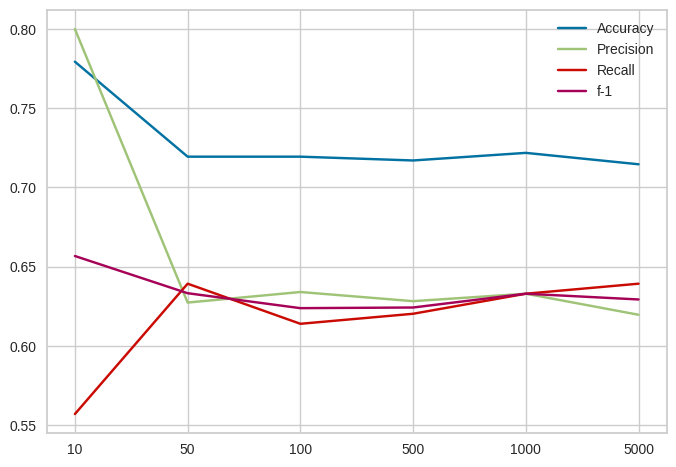

,Accuracy,Precision,Recall,f-1
0,0.779376,0.800000,0.556962,0.656716
1,0.719424,0.627329,0.639241,0.633229
2,0.719424,0.633987,0.613924,0.623794
3,0.717026,0.628205,0.620253,0.624204
4,0.721823,0.632911,0.632911,0.632911
5,0.714628,0.619632,0.639241,0.629283


In [ ]:
# Creación de modelos
models = get_models_est([10, 50, 100, 500, 1000, 5000])

# Entrenamiento de modelos
results_est, names = fit_model(models)

# Gráficas de métricas de aprendizaje
plt.plot(names, results_est)
plt.legend(results_est.columns)
plt.show()

results_est.style.background_gradient(cmap ='viridis')\
        .set_properties(**{'font-size': '20px'})

En este nuevo análisis, podemos observar que aunque con 10 estimadores se obtiene mejor *accuracy* y *precision*, con 20 se obtienen mejores valores para el *recall* y *f1 score*. Ya que los valores de *accuracy* son muy parecidos entre ambos valores (diferencia de 0.007) y el *f1 score* es una métrica que combina *precision* y *recall*, se decidió un valor final de 20 debido a su mayor valor en esta última métrica.

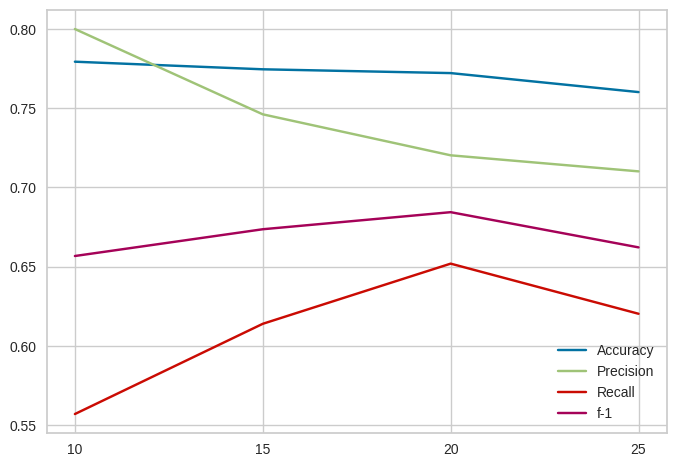

,Accuracy,Precision,Recall,f-1
0,0.779376,0.800000,0.556962,0.656716
1,0.774580,0.746154,0.613924,0.673611
2,0.772182,0.720280,0.651899,0.684385
3,0.760192,0.710145,0.620253,0.662162


In [ ]:
# Creación de modelos
models = get_models_est([10, 15, 20, 25])

# Entrenamiento de modelos
results_est, names = fit_model(models)

# Gráficas de métricas de aprendizaje
plt.plot(names, results_est)
plt.legend(results_est.columns)
plt.show()

results_est.style.background_gradient(cmap ='viridis')\
        .set_properties(**{'font-size': '20px'})

#### **Profundidad máxima y número de hojas**

Estableciendo en las funciones un número de estimador de 20, se prueban distintas profundidades y se obtiene que el modelo es mejor cuando esta es igual a 2 y tiene un número de hojas de 3. Al comparar estas métricas con las anteriores, podemos observar que tanto el *accuracy* como *f1 score* aumentaron.

Además, podemos observar que nuestras métricas se estabilizan a partir de una profundidad de 7.

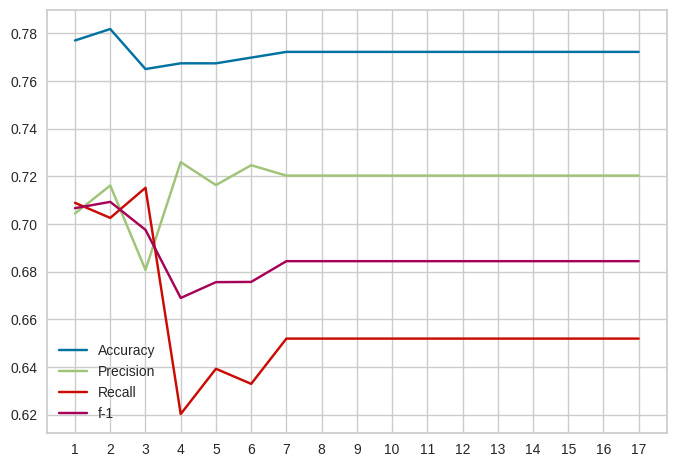

,Accuracy,Precision,Recall,f-1
0,0.776978,0.704403,0.708861,0.706625
1,0.781775,0.716129,0.702532,0.709265
2,0.764988,0.680723,0.715190,0.697531
3,0.767386,0.725926,0.620253,0.668942
4,0.767386,0.716312,0.639241,0.675585
5,0.769784,0.724638,0.632911,0.675676
6,0.772182,0.720280,0.651899,0.684385
7,0.772182,0.720280,0.651899,0.684385
8,0.772182,0.720280,0.651899,0.684385
9,0.772182,0.720280,0.651899,0.684385


In [ ]:
# Creación de modelos
models = get_models_depth(17)

# Entrenamiento de modelos
results_depth, names = fit_model(models)

# Gráficas de métricas de aprendizaje
plt.plot(names, results_depth)
plt.legend(results_depth.columns)
plt.show()

results_depth.style.background_gradient(cmap ='viridis')\
        .set_properties(**{'font-size': '20px'})

#### **Tipos de boost**

Estableciendo los hiperparámetros anteriores, se obtiene que el mejor tipo de boost es el 'goss'. Obteniendo un aumento muy pequeño en *accuracy*,uno un pooco mayor en *F1 score* y unos más significativos en *precision* y *recall*

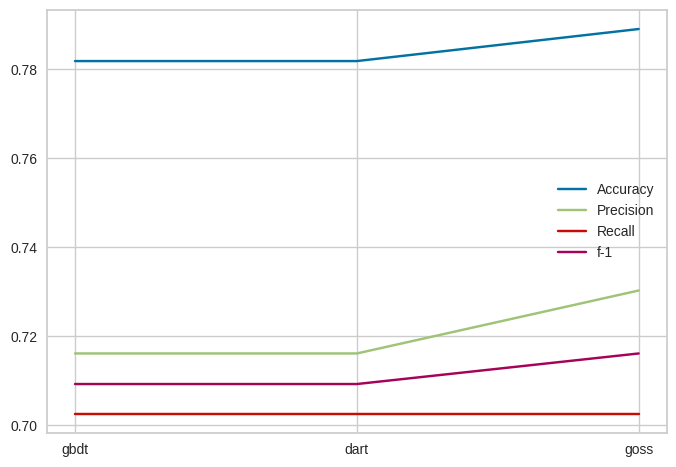

,Accuracy,Precision,Recall,f-1
0,0.781775,0.716129,0.702532,0.709265
1,0.781775,0.716129,0.702532,0.709265
2,0.788969,0.730263,0.702532,0.716129


In [ ]:
# Creación de modelos
models = get_models_boost()

# Entrenamiento de modelos
results_boost, names = fit_model(models)

# Gráficas de métricas de aprendizaje
plt.plot(names, results_boost)
plt.legend(results_boost.columns)
plt.show()

results_boost.style.background_gradient(cmap ='viridis')\
        .set_properties(**{'font-size': '20px'})

#### **Learning rate**

Por último, el hiperparámetro de learning rate produce un mejor cuando este es igual a 0.1 (su valor default), como el rango de 0.1 y 1 es grande, se decidió hacer un análisis secundario para observar el comportamiento dentro de este.

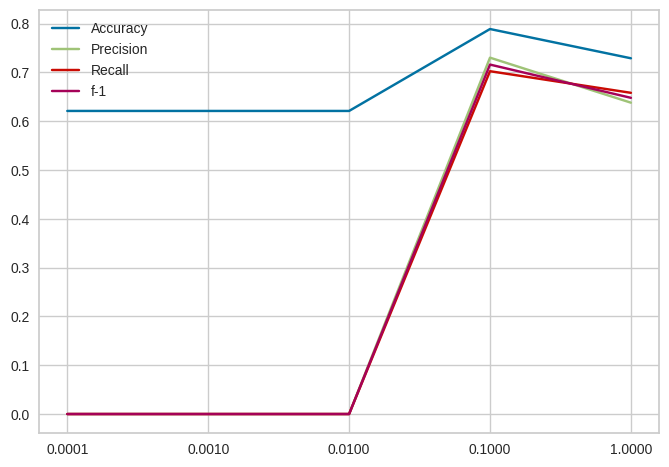

,Accuracy,Precision,Recall,f-1
0,0.621103,0.000000,0.000000,0.000000
1,0.621103,0.000000,0.000000,0.000000
2,0.621103,0.000000,0.000000,0.000000
3,0.788969,0.730263,0.702532,0.716129
4,0.729017,0.638037,0.658228,0.647975


In [ ]:
# Creación de modelos
models = get_models_lr([0.0001, 0.001, 0.01, 0.1, 1.0])

# Entrenamiento de modelos
results_lr, names = fit_model(models)

# Gráficas de métricas de aprendizaje
plt.plot(names, results_lr)
plt.legend(results_lr.columns)
plt.show()

results_lr.style.background_gradient(cmap ='viridis')\
        .set_properties(**{'font-size': '20px'})

Se puede observar que efectivamente un valor de 0.1 es el que produce mejores resultados. Por lo que se decide escoger este valor para el learning rate.

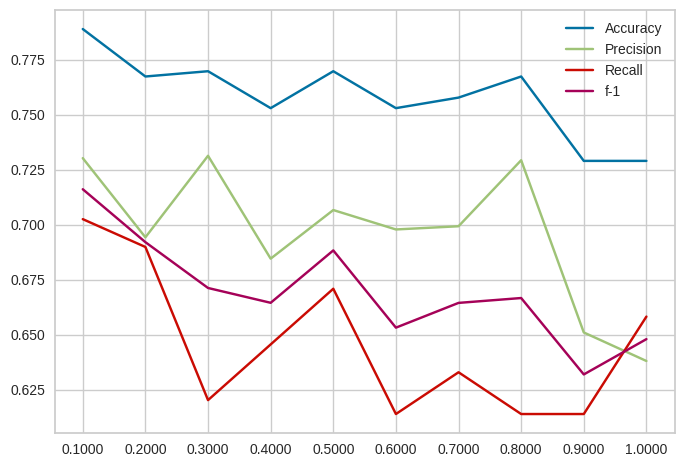

,Accuracy,Precision,Recall,f-1
0,0.788969,0.730263,0.702532,0.716129
1,0.767386,0.694268,0.689873,0.692063
2,0.769784,0.731343,0.620253,0.671233
3,0.752998,0.684564,0.645570,0.664495
4,0.769784,0.706667,0.670886,0.688312
5,0.752998,0.697842,0.613924,0.653199
6,0.757794,0.699301,0.632911,0.664452
7,0.767386,0.729323,0.613924,0.666667
8,0.729017,0.651007,0.613924,0.631922
9,0.729017,0.638037,0.658228,0.647975


In [ ]:
# Creación de modelos
models = get_models_lr([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

# Entrenamiento de modelos
results_lr, names = fit_model(models)

# Gráficas de métricas de aprendizaje
plt.plot(names, results_lr)
plt.legend(results_lr.columns)
plt.show()

results_lr.style.background_gradient(cmap ='viridis')\
        .set_properties(**{'font-size': '20px'})

### Modelo final

Concluyendo, el mejor modelo fue con los siguientes hiperparámetros:
- N_estimators: 20
- Max_depth: 2
- Num_leaves: 3
- Boosting_type: 'goss'
- Learning rate: 0.1

In [ ]:
# Creación modelo fianl
modelo = LGBMClassifier(n_estimators = 20, max_depth = 2, num_leaves = 3,
                        boosting_type = 'goss', learning_rate = 0.1,
                        force_row_wise = True, verbose = -1)

# Entrenamiento
modelo.fit(x_train, y_train)

# Predicciones
y_pred = modelo.predict(test)

# Métricas de aprendizaje
results = pd.DataFrame([[accuracy_score(y_test, y_pred), precision_score(y_test, y_pred),
                    recall_score(y_test, y_pred), f1_score(y_test, y_pred)]])
results.columns = ['Accuracy', 'Precision','Recall','f-1']
results

,Accuracy,Precision,Recall,f-1
0,0.788969,0.730263,0.702532,0.716129


**Matriz de confusión**

Podemos observar que la cantidad de instancias mal predichas son similares para ambas clases.

Se tienen un total de 218 predicciones correctas de no supervivencia, 111 de supervivencia, por otro lado, se tienen 41 casos de no supervivencia predichos incorrectamente y 47 de supervivencia predichos como no supervivencia.

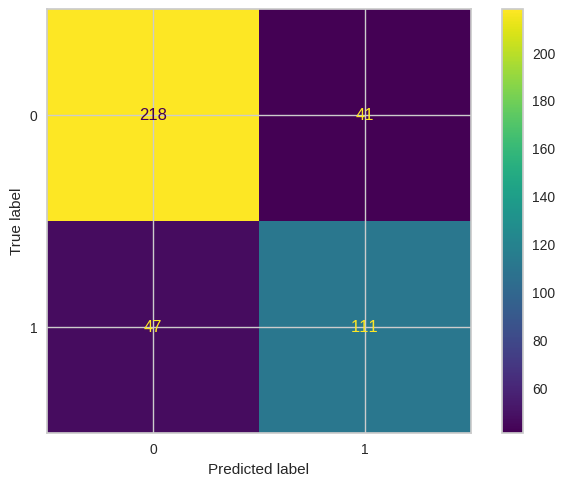

In [ ]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred, labels = modelo.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=modelo.classes_)
disp.plot()
plt.show()

## Gradient Boosting Classifier

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
gb_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.01, max_features=2, max_depth=2, random_state=0)
gb_clf.fit(x_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.01, loss='log_loss', max_depth=2,
                           max_features=2, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_samples_leaf=1,
                           min_samples_split=2, min_weight_fraction_leaf=0.0,
                           n_estimators=100, n_iter_no_change=None,
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [ ]:
y_pred = gb_clf.predict(test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Precisión (Precision): {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')

Accuracy: 0.7961630695443646
Precisión (Precision): 0.7967479674796748
Recall: 0.620253164556962
F1-Score: 0.697508896797153


## Random Forest Classifier

### Liberias

In [ ]:
# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

### Adaptación y evaluación

In [ ]:
rf = RandomForestClassifier()
rf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [ ]:
y_pred = rf.predict(test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy inicial:", accuracy)

Accuracy inicial: 0.7386091127098321


#### _Visualizacion de 3 árboles de decisión del random forest_

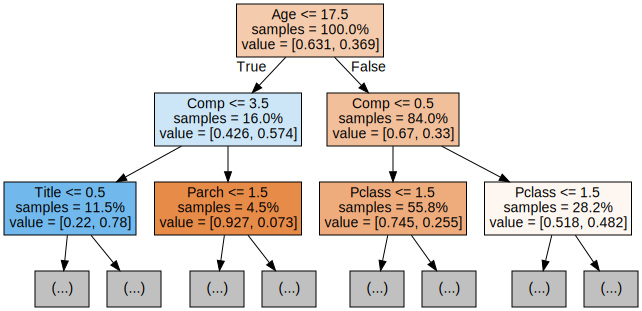

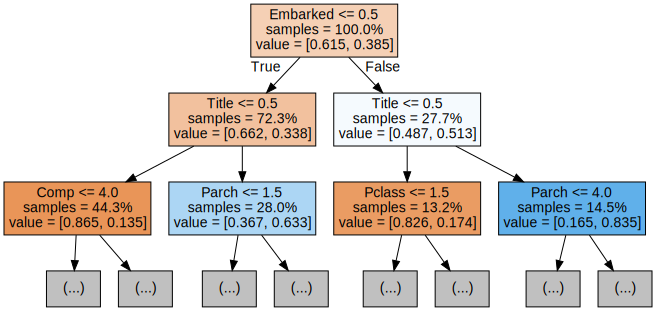

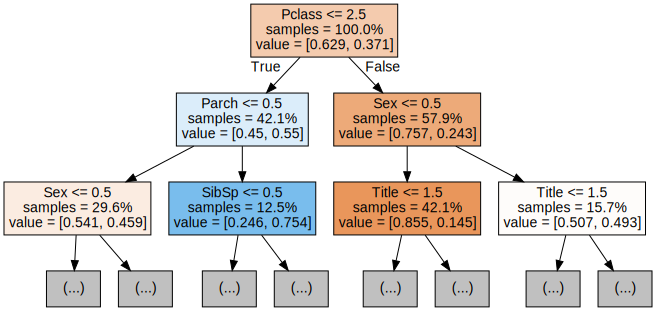

In [ ]:
for i in range(3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=x_train.columns,
                               filled=True,
                               max_depth=2,
                               impurity=False,
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

### Ajuste de hiperparámetros

A continuación se utiliza la función RandomizedSearchCV para encontrar los mejores hiperparámetros entre un rango especificado.

In [ ]:
param_dist = {'n_estimators': randint(40,600),
              'max_depth': randint(1,20)}

rand_search = RandomizedSearchCV(rf,
                                 param_distributions = param_dist,
                                 n_iter=5,
                                 cv=5)

rand_search.fit(x_train, y_train)

best_rf = rand_search.best_estimator_

print('Mejores hiperparámetros:',  rand_search.best_params_)

Mejores hiperparámetros: {'max_depth': 4, 'n_estimators': 107}


In [ ]:
y_pred = best_rf.predict(test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print ("F1: " , f1)

Accuracy: 0.7793764988009593
Precision: 0.70625
Recall: 0.7151898734177216
F1:  0.7106918238993711


Matriz de confusión

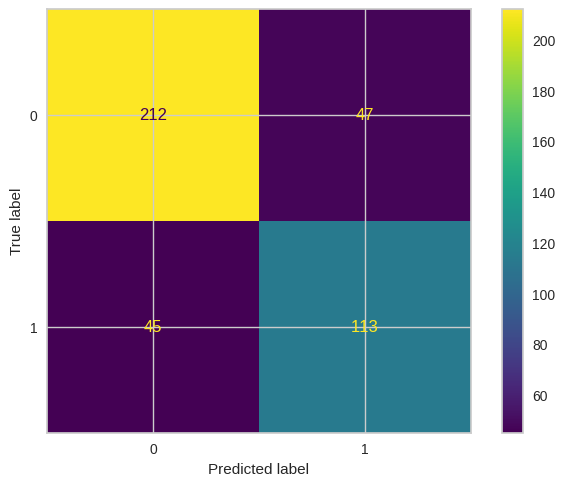

In [ ]:
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

Importancia de las variables

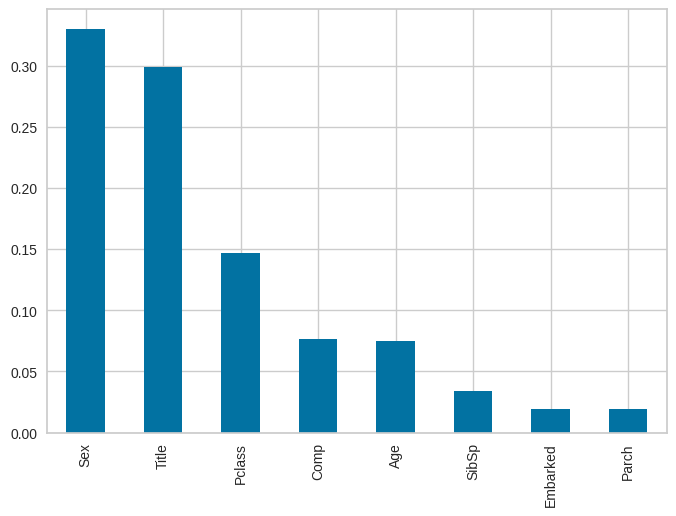

In [ ]:
feature_importances = pd.Series(best_rf.feature_importances_, index=x_train.columns).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances.plot.bar();

## Extreme Gradient Boost

### Librerías

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

### Adaptación y evaluación

In [ ]:
model = XGBClassifier()
model.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='binary:logistic', predictor=None, ...)

In [ ]:
y_pred = model.predict(test)
predictions = [round(value) for value in y_pred]

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print ("F1: " , f1)

Accuracy: 0.7146282973621103
Precision: 0.6258064516129033
Recall: 0.6139240506329114
F1:  0.6198083067092652


#### Matriz de Confusión

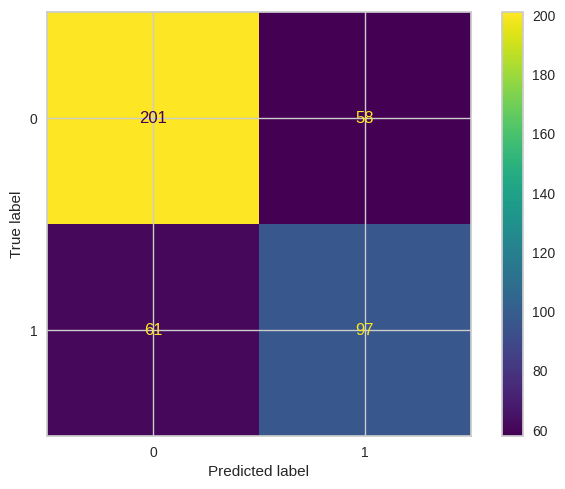

In [ ]:
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

# Selección de modelo

Después de experimentar y analizar los 4 mejores modelos de clasificación presentados por Pycaret, se  realizó la siguiente tabla de métricas de aprendizaje. Como se puede observar, el modelo de Gradient Boosting, tiene el mejor accuracy; no obstante, su Recall y F1-Score disminuyen notablemente, por lo que no se seleccionará como el mejor modelo. Por otra parte, el Light Gradient Boosting cuenta con un mejor Recall y F1-Score, y la disminución del Accuracy con respecto al otro modelo, no es significativa. Por lo mismo, se selecciona este último algoritmo para cumplir el objetivo de este proyecto.

In [ ]:
metricas = pd.DataFrame({"Accuracy": [78.89, 79.61, 77.93, 71.46 ],"Precission": [73.02, 79.67, 70.62, 62.25],
                         "Recall": [70.25,62.02 , 71.51,61.39 ], "F1-Score": [71.61, 69.75, 71.06,61.98]},
                         index = ["Light Gradient Boosting", "Gradient Boosting Machine", "Random Forest", "Extreme Gradient Machine"] )
metricas

,Accuracy,Precission,Recall,F1-Score
Light Gradient Boosting,78.89,73.02,70.25,71.61
Gradient Boosting Machine,79.61,79.67,62.02,69.75
Random Forest,77.93,70.62,71.51,71.06
Extreme Gradient Machine,71.46,62.25,61.39,61.98
